# Utils

Load json embeddings file

In [4]:
import json


def load_embeddings_details_from_json(filename):
    with open(filename, "r") as f:
        return json.load(f)

# Calculate Similarity bw articles

Perform cosine similarity between the actual article and the decoy article chunks <br>
Return a (N * M) matrix where N is the no. of chunks in the actual article and M is the no. of chunks in the decoy article

In [1]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


def find_most_similar(actual_article_embedding_details, decoy_article_embedding_details, model):

    # Find the item with the matching model and extract its embeddings
    for item in actual_article_embedding_details:
        if item["embeddings_model"] == model:
            actual_embeddings = item.get("embeddings")
            
    for item in decoy_article_embedding_details:
        if item["embeddings_model"] == model:
            decoy_embeddings = item.get("embeddings")
    
    # Calculate similarities
    # 90 * 768 + 130 * 768 = 90 * 130
    similarity_matrix = cosine_similarity(actual_embeddings, decoy_embeddings)

    return similarity_matrix


# ArticleSimilarityAnalyzer Overview

The **ArticleSimilarityAnalyzer** is a Python class designed to analyze and visualize the similarity between text articles based on a similarity matrix (N x M matrix of cosine similarities between article chunks). This tool provides insights into the relationships between articles, enabling informed decisions based on similarity metrics.

## Key Features:

### Similarity Metrics Calculation:
- Computes essential metrics including mean, median, standard deviation, maximum, and minimum similarities.
- Determines the proportion of chunk pairs that fall into three similarity categories:
  - **High Similarity**: > 0.8
  - **Moderate Similarity**: 0.6 - 0.8
  - **Low Similarity**: 0.3 - 0.6
- Calculates top percentile similarities (e.g., top 10% and top 25%).

### Relationship Determination:
- Analyzes the computed metrics to categorize the relationship strength between articles into four levels:
  - Strongly Related
  - Moderately Related
  - Weakly Related
  - Unrelated

### Visualization:
- **Distribution Visualization**: Uses seaborn to plot the distribution of chunk similarities, highlighting the defined thresholds.
- **t-SNE Clustering Visualization**: Implements K-Means clustering on the similarity matrix and visualizes the clusters in a 3D space using t-SNE, making it easier to interpret complex relationships visually.

### Confidence Interval Calculation:
- Computes a confidence interval for the mean similarity, providing a statistical basis for the analysis results.


In [2]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
from scipy import stats
from typing import Tuple, Dict
import matplotlib.pyplot as plt
import seaborn as sns

high_similarity_threshold = 0.8
moderate_similarity_threshold = 0.6 
low_similarity_threshold = 0.3
class ArticleSimilarityAnalyzer:
    def __init__(self):
        # Default thresholds based on empirical analysis
        self.high_similarity_threshold = high_similarity_threshold
        self.moderate_similarity_threshold = moderate_similarity_threshold
        self.low_similarity_threshold = low_similarity_threshold
    
    def analyze_similarity_matrix(self, similarity_matrix: np.ndarray) -> Dict:
        """
        Analyze similarity matrix to determine if two articles are related
        
        Parameters:
        similarity_matrix (np.ndarray): N*M matrix of cosine similarities between chunks
        
        Returns:
        Dict containing analysis results and relationship determination
        """
        # Calculate various similarity metrics
        metrics = {
            'mean_similarity': np.mean(similarity_matrix),
            'median_similarity': np.median(similarity_matrix),
            'std_similarity': np.std(similarity_matrix),
            'max_similarity': np.max(similarity_matrix),
            'min_similarity': np.min(similarity_matrix),
            
            # Percentage of chunk pairs above thresholds between
            'high_similarity_ratio': np.mean(similarity_matrix > self.high_similarity_threshold),
            'moderate_similarity_ratio': np.mean((similarity_matrix > moderate_similarity_threshold) & 
                     (similarity_matrix < high_similarity_threshold)),
            'low_similarity_ratio': np.mean((similarity_matrix > low_similarity_threshold) & 
                     (similarity_matrix < moderate_similarity_threshold)),
            # 0 0 1 4 5 4 5 9
            # Top percentile similarities
            'top_10_percentile': np.percentile(similarity_matrix, 90),
            'top_25_percentile': np.percentile(similarity_matrix, 75)
        }
        
        # Calculate chunk-wise max similarities
        max_similarities_per_chunk1 = np.max(similarity_matrix, axis=1)
        max_similarities_per_chunk2 = np.max(similarity_matrix, axis=0)
        
        # Calculate chunk-wise min similarities
        min_similarities_per_chunk1 = np.min(similarity_matrix, axis=1)
        min_similarities_per_chunk2 = np.min(similarity_matrix, axis=0)
        
        metrics.update({
            'avg_max_similarity_chunk1': np.mean(max_similarities_per_chunk1),
            'avg_max_similarity_chunk2': np.mean(max_similarities_per_chunk2),
            'avg_min_similarity_chunk1': np.mean(min_similarities_per_chunk1),
            'avg_min_similarity_chunk2': np.mean(min_similarities_per_chunk2)
        })
        
        # Determine relationship strength
        relationship = self._determine_relationship(metrics)
        
        return {
            'metrics': metrics,
            'relationship': relationship,
            'max_similarities_chunk1': max_similarities_per_chunk1,
            'max_similarities_chunk2': max_similarities_per_chunk2
        }
    
    def _determine_relationship(self, metrics: Dict) -> str:
        """
        Determine the relationship strength based on multiple criteria
        """
        # Define scoring system
        score = 0
        
        # Criterion 1: Mean similarity
        if metrics['mean_similarity'] > self.high_similarity_threshold:
            score += 3
        elif metrics['mean_similarity'] > self.moderate_similarity_threshold:
            score += 2
        elif metrics['mean_similarity'] > self.low_similarity_threshold:
            score += 1
            
        # Criterion 2: High similarity ratio
        if metrics['high_similarity_ratio'] > 0.3:  # More than 30% chunks highly similar
            score += 3
        elif metrics['high_similarity_ratio'] > 0.15:  # More than 15% chunks highly similar
            score += 2
        elif metrics['high_similarity_ratio'] > 0.05:  # More than 5% chunks highly similar
            score += 1
            
        # Criterion 3: Average max similarities
        avg_max_sim = (metrics['avg_max_similarity_chunk1'] + metrics['avg_max_similarity_chunk2']) / 2
        if avg_max_sim > self.high_similarity_threshold:
            score += 3
        elif avg_max_sim > self.moderate_similarity_threshold:
            score += 2
        elif avg_max_sim > self.low_similarity_threshold:
            score += 1
        
        # Determine relationship based on total score
        if score >= 7:
            return "Strongly Related"
        elif score >= 4:
            return "Moderately Related"
        elif score >= 2:
            return "Weakly Related"
        else:
            return "Unrelated"
    
    def visualize_similarity_distribution(self, similarity_matrix: np.ndarray) -> None:
        """
        Visualize the distribution of similarities and thresholds
        """
        plt.figure(figsize=(12, 6))
        
        # Plot similarity distribution
        sns.histplot(similarity_matrix.flatten(), bins=50, kde=True)
        
        # Add threshold lines
        plt.axvline(x=self.high_similarity_threshold, color='g', linestyle='--', 
                   label=f'High Similarity ({self.high_similarity_threshold})')
        plt.axvline(x=self.moderate_similarity_threshold, color='y', linestyle='--',
                   label=f'Moderate Similarity ({self.moderate_similarity_threshold})')
        plt.axvline(x=self.low_similarity_threshold, color='r', linestyle='--',
                   label=f'Low Similarity ({self.low_similarity_threshold})')
        
        plt.title('Distribution of Chunk Similarities')
        plt.xlabel('Cosine Similarity')
        plt.ylabel('Count')
        plt.legend()
        
    def calculate_confidence_interval(self, similarity_matrix: np.ndarray, 
                                   confidence_level: float = 0.95) -> Tuple[float, float]:
        """
        Calculate confidence interval for mean similarity
        """
        flat_similarities = similarity_matrix.flatten()
        mean = np.mean(flat_similarities)
        std_error = stats.sem(flat_similarities)
        ci = stats.t.interval(confidence_level, len(flat_similarities)-1, mean, std_error)
        return ci

    def visualize_tsne_clusters(self, similarity_matrix, n_clusters=5, perplexity=30, n_iter=500):
        """
        Perform K-means clustering and visualize clusters in 3D using t-SNE.
        
        Parameters:
        - similarity_matrix: np.ndarray, similarity matrix to cluster and visualize.
        - n_clusters: int, number of clusters for K-means.
        - perplexity: int, t-SNE perplexity (balance between local and global views).
        - n_iter: int, number of t-SNE iterations (higher for convergence).
    
        Returns:
        - None. Displays a 3D plot of the clustered data.
        """
        # Perform K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(similarity_matrix)
    
        # Apply t-SNE for dimensionality reduction to 3D
        tsne = TSNE(n_components=3, random_state=42, perplexity=perplexity, n_iter=n_iter)
        reduced_data = tsne.fit_transform(similarity_matrix)
    
        # Plot the clusters in a 3D scatter plot
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d', elev=20, azim=120)
    
        # Define a color map for cluster visualization
        colors = plt.cm.get_cmap('viridis', n_clusters)
    
        # Scatter plot for each cluster
        for cluster in range(n_clusters):
            cluster_points = reduced_data[labels == cluster]
            ax.scatter(
                cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
                s=100, color=colors(cluster), alpha=0.7, label=f'Cluster {cluster + 1}'
            )
    
        # Customize the plot
        ax.set_title('3D t-SNE Cluster Visualization', fontsize=16, fontweight='bold')
        ax.set_xlabel('t-SNE Component 1', fontsize=12)
        ax.set_ylabel('t-SNE Component 2', fontsize=12)
        ax.set_zlabel('t-SNE Component 3', fontsize=12)
        ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=10)
        ax.grid(True)
    
        # Adjust layout and display the plot
        plt.tight_layout()
        plt.show()


# Example usage
def interpret_results(analysis_results: Dict) -> str:
    """
    Provide detailed interpretation of analysis results
    """
    metrics = analysis_results['metrics']
    relationship = analysis_results['relationship']
    
    interpretation = f"""
    Analysis Results:
    
    1. Overall Relationship: {relationship}
    
    2. Similarity Metrics:
       - Mean Similarity: {metrics['mean_similarity']:.3f}
       - Median Similarity: {metrics['median_similarity']:.3f}
       - Maximum Similarity: {metrics['max_similarity']:.3f}
       - Minimum Similarity: {metrics['min_similarity']:.3f}
       
    3. Distribution Analysis:
       - High Similarity Chunks (>{high_similarity_threshold}): {metrics['high_similarity_ratio']*100:.1f}%
       - Moderate Similarity Chunks (>{moderate_similarity_threshold} and <{high_similarity_threshold}): {metrics['moderate_similarity_ratio']*100:.1f}%
       - Low Similarity Chunks (>{low_similarity_threshold} and {moderate_similarity_threshold}): {metrics['low_similarity_ratio']*100:.1f}%
       
    4. Chunk-wise Analysis:
       - Average Max Similarity (Article 1): {metrics['avg_max_similarity_chunk1']:.3f}
       - Average Max Similarity (Article 2): {metrics['avg_max_similarity_chunk2']:.3f}
       - Average Min Similarity (Article 1): {metrics['avg_min_similarity_chunk1']:.3f}
       - Average Min Similarity (Article 2): {metrics['avg_min_similarity_chunk2']:.3f}
       
    5. Top Percentile Analysis:
       - Top 10% of similarities above: {metrics['top_10_percentile']:.3f}
       - Top 25% of similarities above: {metrics['top_25_percentile']:.3f}
    """
    return interpretation

### Analysis between actual article and decoy articles:

### Actual article (PMC_7614604):
Lung adenocarcinoma promotion by air pollutants

### Decoy article (PMC_9098652):
Role of adipose tissue macrophages in obesity-related disorders

In [5]:
actual_article_id = "PMC_7614604"
decoy_article_id = "PMC_9098652"
embedding_model = "pubmedbert"

actual_article_embeddings_path = f"../data/embeddings/{actual_article_id}_embeddings.json"
decoy_article_embeddings_path = f"../data/decoy_docs/embeddings/{decoy_article_id}_embeddings.json"

actual_article_embedding_details = load_embeddings_details_from_json(filename=actual_article_embeddings_path)
decoy_article_embedding_details = load_embeddings_details_from_json(filename=decoy_article_embeddings_path)

sim_matrix = find_most_similar(actual_article_embedding_details, decoy_article_embedding_details, embedding_model)

Decoy Article Id: PMC_9098652


/Users/nadarajanrajan/tw_workspace/gilead_setup/gilead-pubtator3.0/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/var/folders/4m/rmk_mgcx65j7r_8nkz68kc3r0000gn/T/ipykernel_6313/461732753.py:175: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', n_clusters)


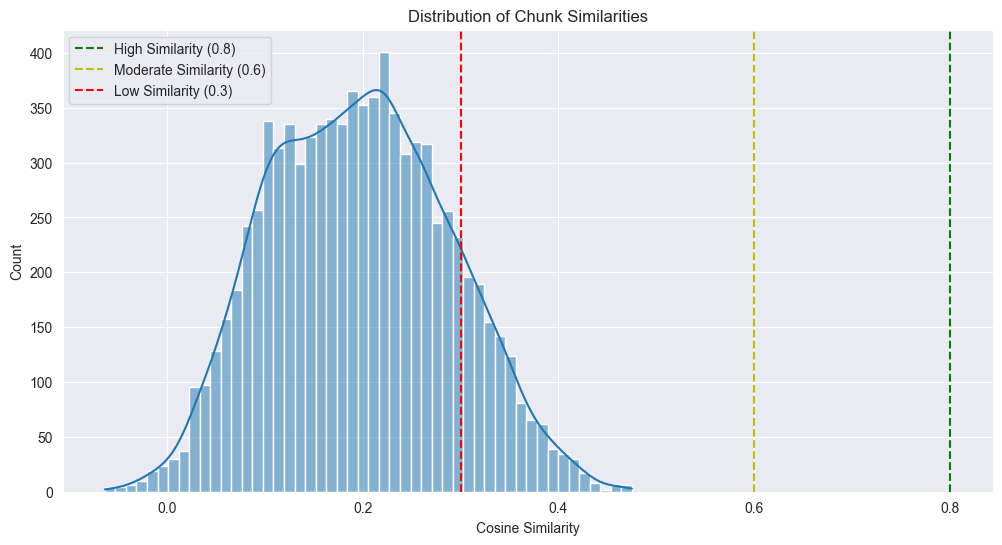

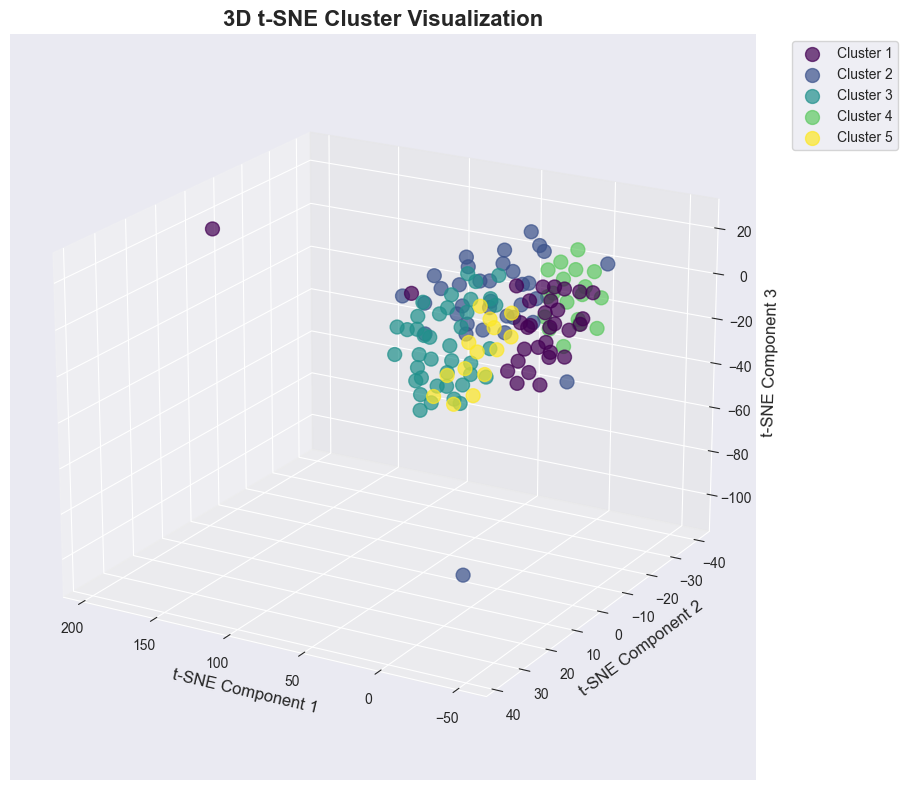


    Analysis Results:
    
    1. Overall Relationship: Unrelated
    
    2. Similarity Metrics:
       - Mean Similarity: 0.197
       - Median Similarity: 0.195
       - Maximum Similarity: 0.475
       - Minimum Similarity: -0.063
       
    3. Distribution Analysis:
       - High Similarity Chunks (>0.8): 0.0%
       - Moderate Similarity Chunks (>0.6 and <0.8): 0.0%
       - Low Similarity Chunks (>0.3 and 0.6): 14.2%
       
    4. Chunk-wise Analysis:
       - Average Max Similarity (Article 1): 0.293
       - Average Max Similarity (Article 2): 0.382
       - Average Min Similarity (Article 1): 0.112
       - Average Min Similarity (Article 2): 0.009
       
    5. Top Percentile Analysis:
       - Top 10% of similarities above: 0.319
       - Top 25% of similarities above: 0.262
    
(0.19471821735560482, 0.19858942417641964)


In [6]:
print(f"Decoy Article Id: {decoy_article_id}")
# Initialize analyzer
analyzer = ArticleSimilarityAnalyzer()

# Analyze similarity matrix
similarity_matrix = sim_matrix
results = analyzer.analyze_similarity_matrix(similarity_matrix)

# Visualize distribution
analyzer.visualize_similarity_distribution(similarity_matrix)
analyzer.visualize_tsne_clusters(similarity_matrix)

# Get confidence interval
ci = analyzer.calculate_confidence_interval(similarity_matrix)

# Print interpretation
print(interpret_results(results))

print(ci)

### Actual article (PMC_7614604):
Lung adenocarcinoma promotion by air pollutants

### Decoy article (PMC_10452697):
A Chamber-Based Digital PCR Based on a Microfluidic Chip for the Absolute Quantification and Analysis of KRAS Mutation

In [7]:
actual_article_id = "PMC_7614604"
decoy_article_id = "PMC_10452697"
embedding_model = "pubmedbert"

actual_article_embeddings_path = f"../data/embeddings/{actual_article_id}_embeddings.json"
decoy_article_embeddings_path = f"../data/decoy_docs/embeddings/{decoy_article_id}_embeddings.json"

actual_article_embedding_details = load_embeddings_details_from_json(filename=actual_article_embeddings_path)
decoy_article_embedding_details = load_embeddings_details_from_json(filename=decoy_article_embeddings_path)

sim_matrix = find_most_similar(actual_article_embedding_details, decoy_article_embedding_details, embedding_model)

Decoy Article Id: PMC_10452697


/Users/nadarajanrajan/tw_workspace/gilead_setup/gilead-pubtator3.0/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/var/folders/4m/rmk_mgcx65j7r_8nkz68kc3r0000gn/T/ipykernel_6313/461732753.py:175: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', n_clusters)


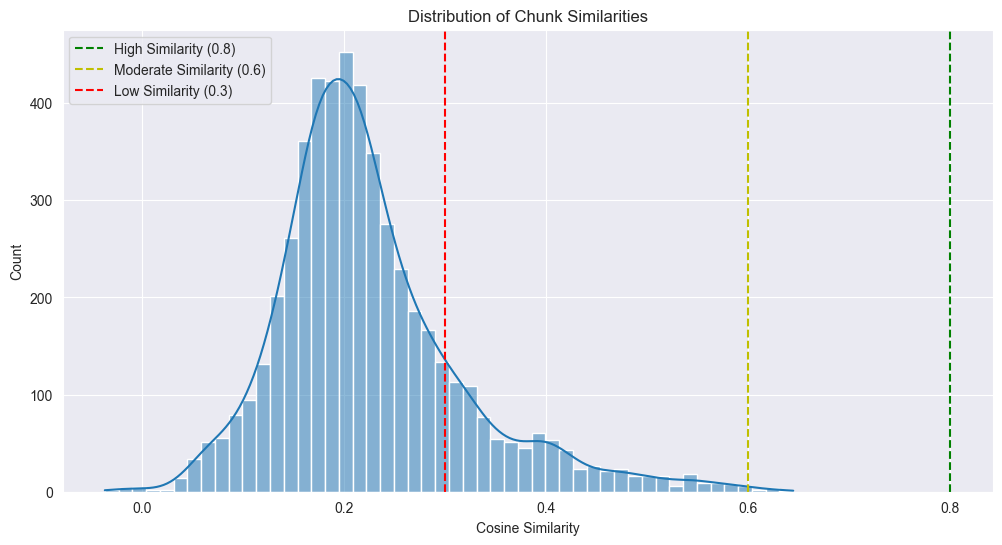

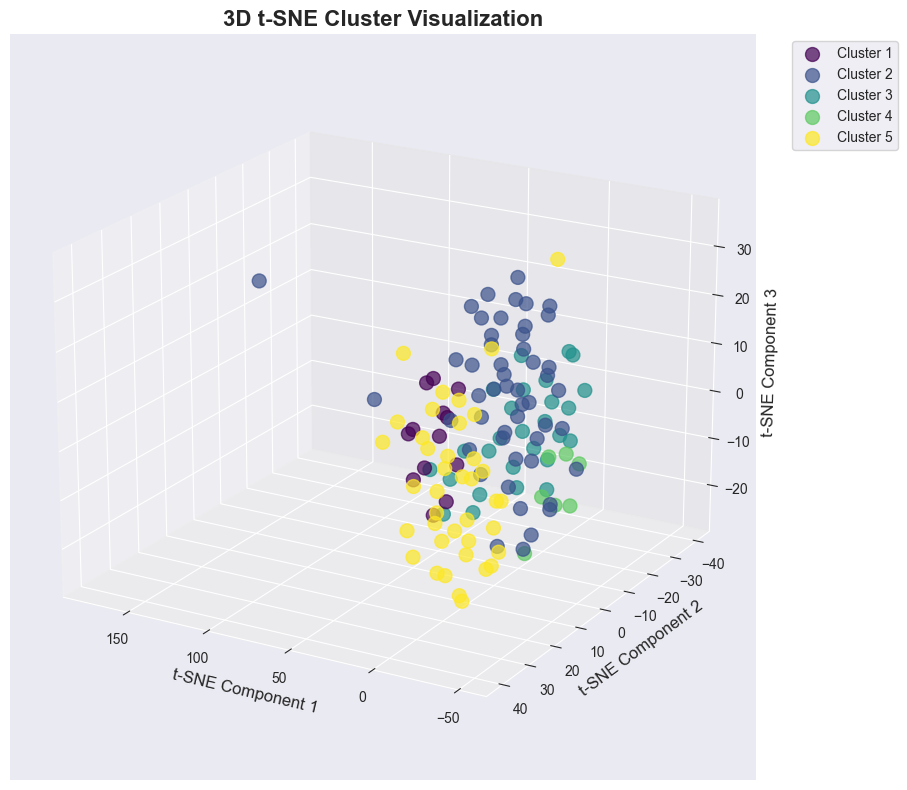


    Analysis Results:
    
    1. Overall Relationship: Unrelated
    
    2. Similarity Metrics:
       - Mean Similarity: 0.225
       - Median Similarity: 0.208
       - Maximum Similarity: 0.645
       - Minimum Similarity: -0.037
       
    3. Distribution Analysis:
       - High Similarity Chunks (>0.8): 0.0%
       - Moderate Similarity Chunks (>0.6 and <0.8): 0.2%
       - Low Similarity Chunks (>0.3 and 0.6): 16.4%
       
    4. Chunk-wise Analysis:
       - Average Max Similarity (Article 1): 0.334
       - Average Max Similarity (Article 2): 0.538
       - Average Min Similarity (Article 1): 0.122
       - Average Min Similarity (Article 2): 0.066
       
    5. Top Percentile Analysis:
       - Top 10% of similarities above: 0.343
       - Top 25% of similarities above: 0.263
    
(0.22216723340846292, 0.227220569788693)


In [8]:
print(f"Decoy Article Id: {decoy_article_id}")
# Initialize analyzer
analyzer = ArticleSimilarityAnalyzer()

# Analyze similarity matrix
similarity_matrix = sim_matrix
results = analyzer.analyze_similarity_matrix(similarity_matrix)

# Visualize distribution
analyzer.visualize_similarity_distribution(similarity_matrix)
analyzer.visualize_tsne_clusters(similarity_matrix)

# Get confidence interval
ci = analyzer.calculate_confidence_interval(similarity_matrix)

# Print interpretation
print(interpret_results(results))

print(ci)

### Analysis between actual article and unrelated articles:

### Actual article (PMC_7614604):
Lung adenocarcinoma promotion by air pollutants

### Unrelated article (PMC_10163802):
Diabetes mellitus-related hospital admissions and prescriptions of antidiabetic agents in England and Wales: an ecological study

In [9]:
actual_article_id = "PMC_7614604"
decoy_article_id = "PMC_10163802"
embedding_model = "pubmedbert"

actual_article_embeddings_path = f"../data/embeddings/{actual_article_id}_embeddings.json"
decoy_article_embeddings_path = f"../data/decoy_docs/embeddings/{decoy_article_id}_embeddings.json"

actual_article_embedding_details = load_embeddings_details_from_json(filename=actual_article_embeddings_path)
decoy_article_embedding_details = load_embeddings_details_from_json(filename=decoy_article_embeddings_path)

sim_matrix = find_most_similar(actual_article_embedding_details, decoy_article_embedding_details, embedding_model)

Decoy Article Id: PMC_10163802


/Users/nadarajanrajan/tw_workspace/gilead_setup/gilead-pubtator3.0/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/var/folders/4m/rmk_mgcx65j7r_8nkz68kc3r0000gn/T/ipykernel_6313/461732753.py:175: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', n_clusters)


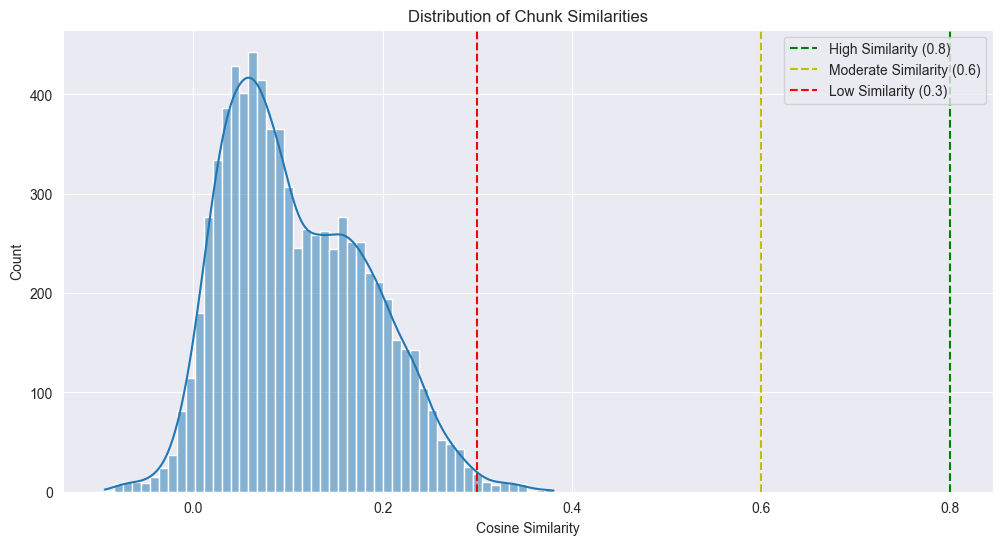

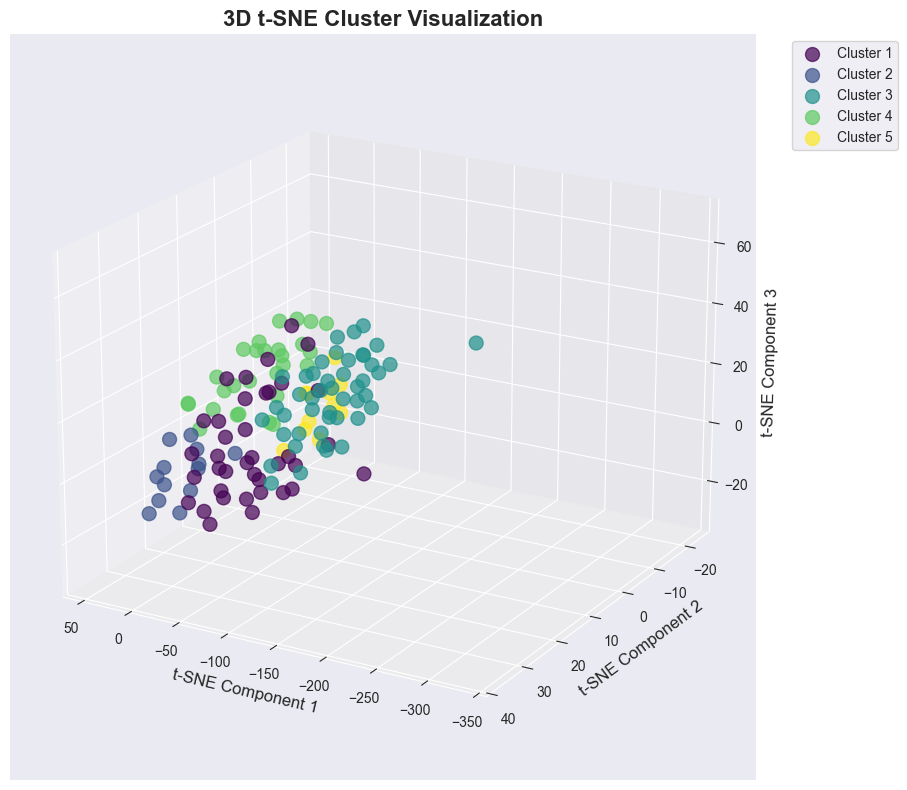


    Analysis Results:
    
    1. Overall Relationship: Unrelated
    
    2. Similarity Metrics:
       - Mean Similarity: 0.109
       - Median Similarity: 0.095
       - Maximum Similarity: 0.381
       - Minimum Similarity: -0.094
       
    3. Distribution Analysis:
       - High Similarity Chunks (>0.8): 0.0%
       - Moderate Similarity Chunks (>0.6 and <0.8): 0.0%
       - Low Similarity Chunks (>0.3 and 0.6): 0.7%
       
    4. Chunk-wise Analysis:
       - Average Max Similarity (Article 1): 0.165
       - Average Max Similarity (Article 2): 0.319
       - Average Min Similarity (Article 1): 0.049
       - Average Min Similarity (Article 2): -0.053
       
    5. Top Percentile Analysis:
       - Top 10% of similarities above: 0.215
       - Top 25% of similarities above: 0.164
    
(0.10713691650028055, 0.11050148866837765)


In [10]:
print(f"Decoy Article Id: {decoy_article_id}")
# Initialize analyzer
analyzer = ArticleSimilarityAnalyzer()

# Analyze similarity matrix
similarity_matrix = sim_matrix
results = analyzer.analyze_similarity_matrix(similarity_matrix)

# Visualize distribution
analyzer.visualize_similarity_distribution(similarity_matrix)
analyzer.visualize_tsne_clusters(similarity_matrix)

# Get confidence interval
ci = analyzer.calculate_confidence_interval(similarity_matrix)

# Print interpretation
print(interpret_results(results))

print(ci)